In [2]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from abc import ABCMeta, abstractmethod

from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import FactorizedNormalPrior

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [112]:
data = SynthDataset(x_dim=2, N=500, num_clusters=3, seed=0, labeled=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

## Analyzing

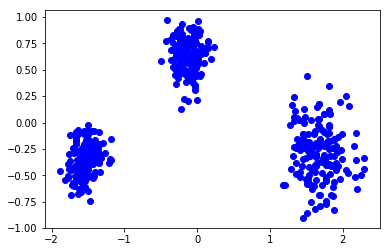

In [113]:
x = data.X.numpy()
x_r, x_f = pca(x, x)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')

## BGAN

In [159]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

[autoreload of bgan.bgan_nogen failed: Traceback (most recent call last):
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 693, in exec_module
  File "<frozen importlib._bootstrap_external>", line 799, in get_code
  File "<frozen importlib._bootstrap_external>", line 759, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _

In [160]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, num_samples, shape=None, init=None):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples, init)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples, init):
        if init is None:
            z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        else:
            z = torch.from_numpy(init).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]


class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, h_dim)
        self.x_dim = x_dim
        self.K = 2
    
    def build_net(self, x_dim, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.network(input)
        return output

In [161]:
from bgan.bgan_nogen import BGANNG, FixedSizeDataset

In [183]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [184]:
prior = FactorizedNormalPrior(std=5.)
init = np.copy(data[0].numpy())[None, :]
gen = GeneratorNetwork(1, init=init)
disc = DiscriminatorNetwork(2, 100)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-2, num_data=len(data), disc_lr=1e-2, observed_gen=100)
samples = []

In [185]:
def visualize(samples, x_min=None, x_max=None, y_min=None, y_max=None, with_samples=True, n_grid=500):
    min_samples = np.array((np.min(samples[:, 0]), np.min(samples[:, 1])))
    max_samples = np.array((np.max(samples[:, 0]), np.max(samples[:, 1])))
    min_x = np.array((np.min(x[:, 0]), np.min(x[:, 1])))
    max_x = np.array((np.max(x[:, 0]), np.max(x[:, 1])))
    min_ = np.min(np.vstack([min_samples[None, :], min_x[None, :]]), axis=0)
    max_ = np.max(np.vstack([max_samples[None, :], max_x[None, :]]), axis=0)
#     print(min_, max_)
#     print(np.hstack([max_samples[None, :], max_x[None, :]]))
    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    
    probs = disc.forward(Variable(torch.from_numpy(w_grid).float())).data.numpy()
    probs = (probs[:, 0]).reshape((n_grid, n_grid))
    plt.figure(figsize=(15, 10))
    CS = plt.contour(w_grid_x, w_grid_y, probs)
#     print(w_grid_x)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Simplest default with labels')
    plt.plot(x[:, 0], x[:, 1], 'bo', alpha=0.1)
    if with_samples:
        plt.plot(samples[:, 0], samples[:, 1], '-r')
        plt.plot(samples[-1, 0], samples[-1, 1], 'ro', markersize=10)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    im = plt.imshow(probs, interpolation='bilinear', origin='lower',
            cmap='hot', extent=(x_min, x_max, y_min, y_max))

In [186]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(1000):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        samples.append(np.copy(gen.z_v.data.numpy()))
        bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%100:
        print(epoch)
samples = np.vstack(samples)

/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0
100
200
300
400
500
600
700
800
900


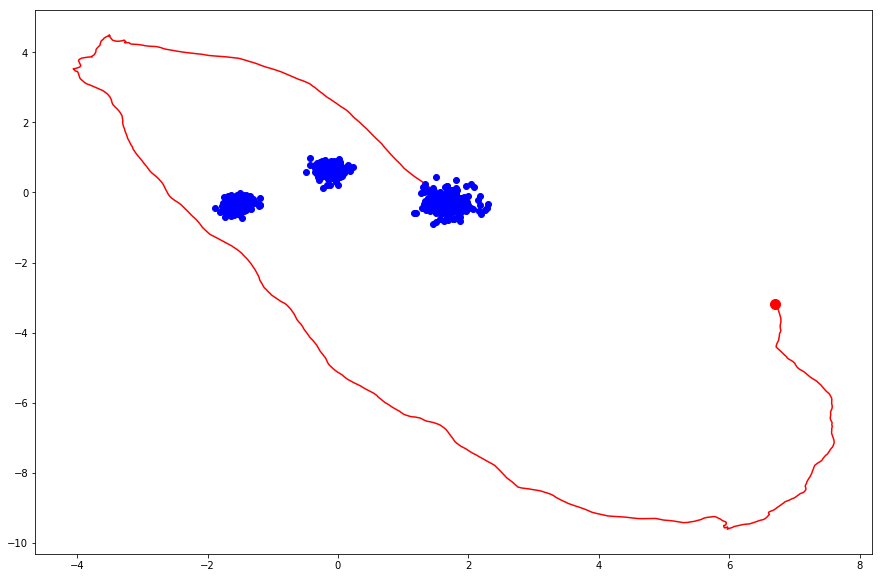

In [187]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(x, samples)
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

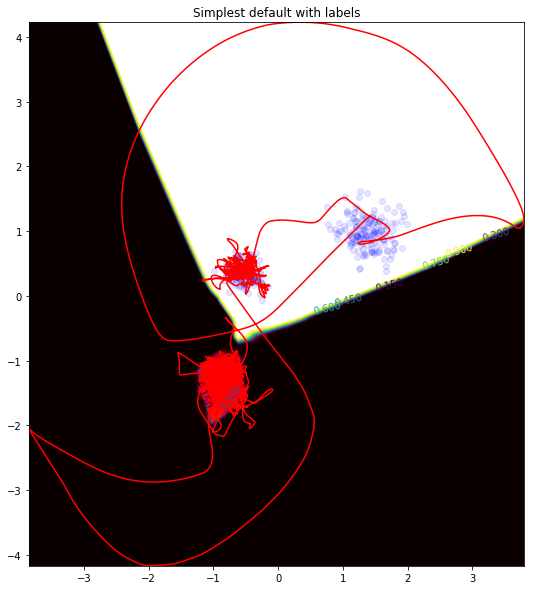

In [177]:
visualize(samples)

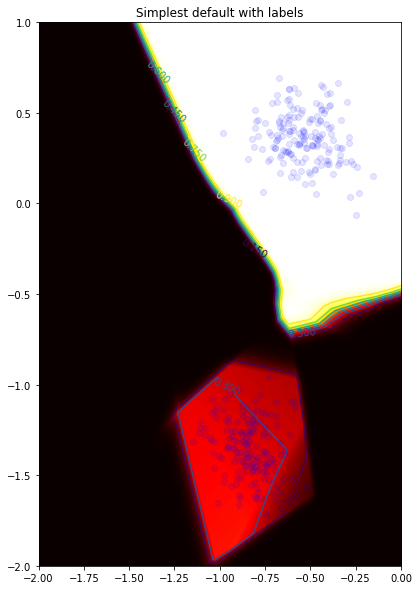

In [179]:
visualize(samples, x_min=-2., x_max=0., y_min=-2, y_max=1., with_samples=False)

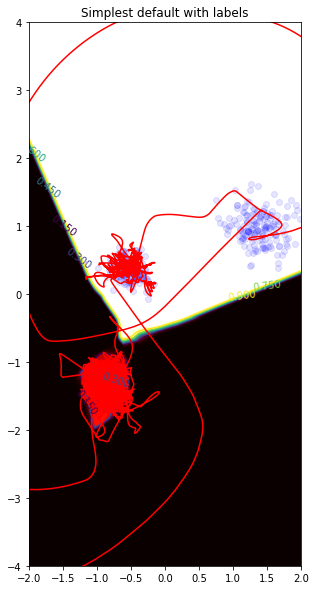

In [180]:
visualize(samples, x_min=-2, x_max=2, y_min=-4, y_max=4, with_samples=True)

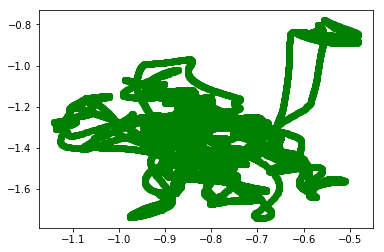

In [65]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)
plt.plot(fake_samples[:, 0], fake_samples[:, 1], 'go')

In [66]:
def thinning(sample_arr, freq=100):
    new_sample_arr = []
    for i, sample in enumerate(sample_arr):
        if not i % freq:
            new_sample_arr.append(sample)
    return np.array(new_sample_arr)

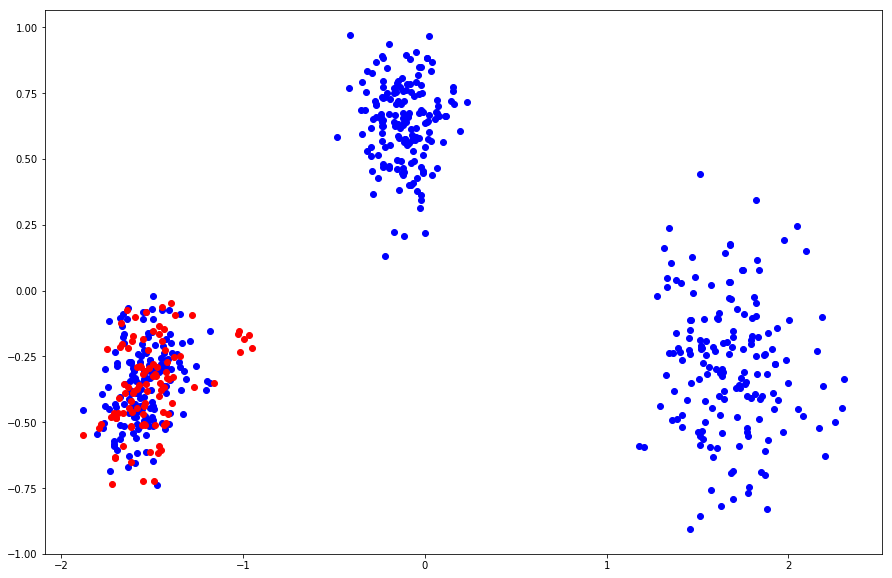

In [68]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, freq=100)[-100:]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

## Now let's try it on a high-dimensional problem
This part of code is outdated

In [24]:
x_dim = 10
data = SynthDataset(x_dim=x_dim, N=5000, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

In [25]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [26]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(x_dim, 1)
disc = DiscriminatorNetwork(x_dim, 2, 200)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, prior, disc, alpha=.1, eta=1e-6, num_data=len(data), disc_lr=1e-4)
samples = []

In [30]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(100000):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%10:
        samples.append(np.copy(gen.z_v.data.numpy()))
    if not epoch%100:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
samples = np.vstack(samples)

0
0.0794081
0.134094
100
0.00364006
0.0078955
200
0.0104508
0.00588205
300
0.0180467
0.0130334
400
0.0443816
0.0336477
500
0.126449
0.0266968
600
0.0302198
0.0178494
700
0.0106555
0.0171092
800
0.0106351
0.00707561
900
0.0232883
0.0577635
1000
0.0238006
0.128255
1100
0.0209855
0.0119937
1200
0.00980734
0.0225261
1300
0.0345147
0.0229698
1400
0.0369764
0.0472964
1500
0.156943
0.0363977
1600
0.114765
0.0569871
1700
0.0317473
0.0326917
1800
0.0167567
0.0191388
1900
0.0349534
0.0094834
2000
0.0105887
0.00981981
2100
0.00640212
0.00822267
2200
0.0480896
0.00422698
2300
0.051422
0.0284478
2400
0.00214693
0.0174838
2500
0.0132876
0.0258962
2600
0.0285147
0.0610568
2700
0.0106905
0.0218781
2800
0.000351337
0.00792857
2900
0.00423882
0.0082315
3000
0.00260111
0.00923046
3100
0.00952854
0.0112472
3200
0.00333278
0.00792311
3300
0.00653892
0.0111191
3400
0.0186311
0.00903095
3500
0.00775335
0.00651598
3600
0.00347632
0.00468075
3700
0.0105406
0.00329787
3800
0.00763619
0.00494503
3900
0.00720928


32000
0.0336276
0.037421
32100
0.0760133
0.0709419
32200
0.0598136
0.0770547
32300
0.0525214
0.0533153
32400
0.0728403
0.0465467
32500
0.0452919
0.0601997
32600
0.0434608
0.0595799
32700
0.0634067
0.0281279
32800
0.0407431
0.0308485
32900
0.0401015
0.0167998
33000
0.03332
0.0458352
33100
0.0885602
0.0744931
33200
0.0567737
0.032649
33300
0.0565493
0.0628273
33400
0.0660942
0.0584976
33500
0.0314624
0.00792757
33600
0.0148876
0.00179262
33700
0.0548035
0.0192448
33800
0.0569634
0.0541197
33900
0.0508339
0.0131883
34000
0.0703419
0.0806995
34100
0.0282607
0.022857
34200
0.0472217
0.0612024
34300
0.0284632
0.0462925
34400
0.0465827
0.0426644
34500
0.0522139
0.048656
34600
0.0608848
0.061483
34700
0.0169968
0.00877833
34800
0.0578157
0.0499579
34900
0.0620411
0.0896373
35000
0.0420548
0.0603943
35100
0.0436337
0.0633714
35200
0.0392553
0.0570326
35300
0.018191
0.0157888
35400
0.0831311
0.108654
35500
0.0630339
0.0222964
35600
0.0516535
0.0688705
35700
0.0207284
0.0358414
35800
0.0478528
0.

KeyboardInterrupt: 

In [31]:
samples = np.vstack(samples)

In [32]:
samples.shape

(5087, 10)

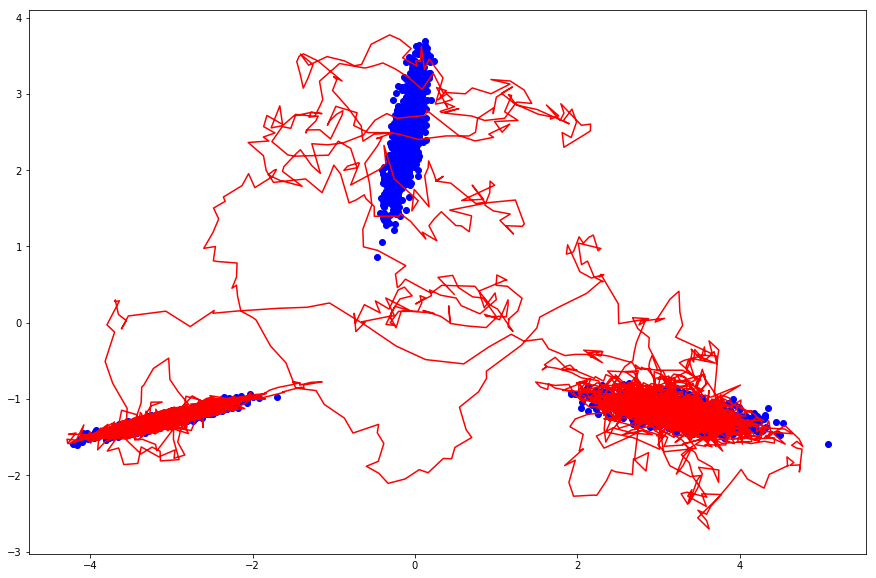

In [38]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

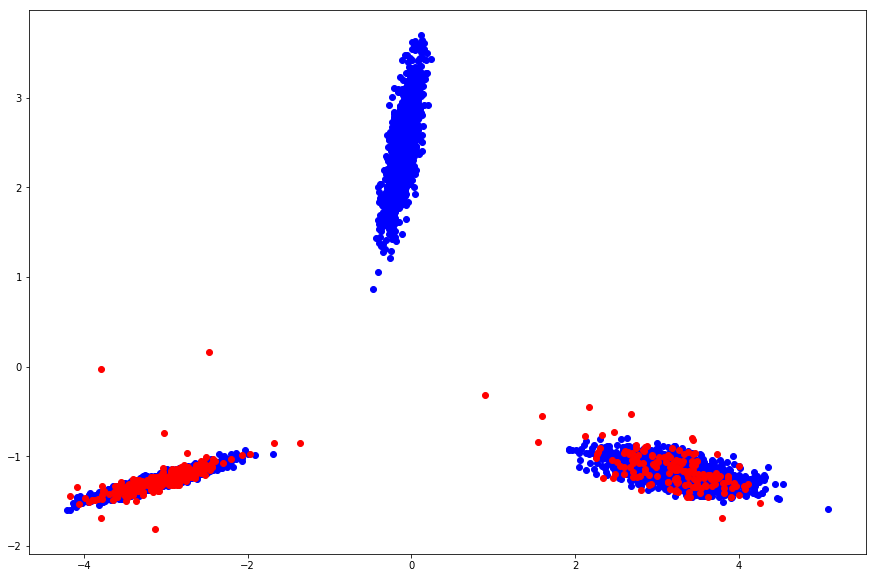

In [41]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, 10)[100:]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

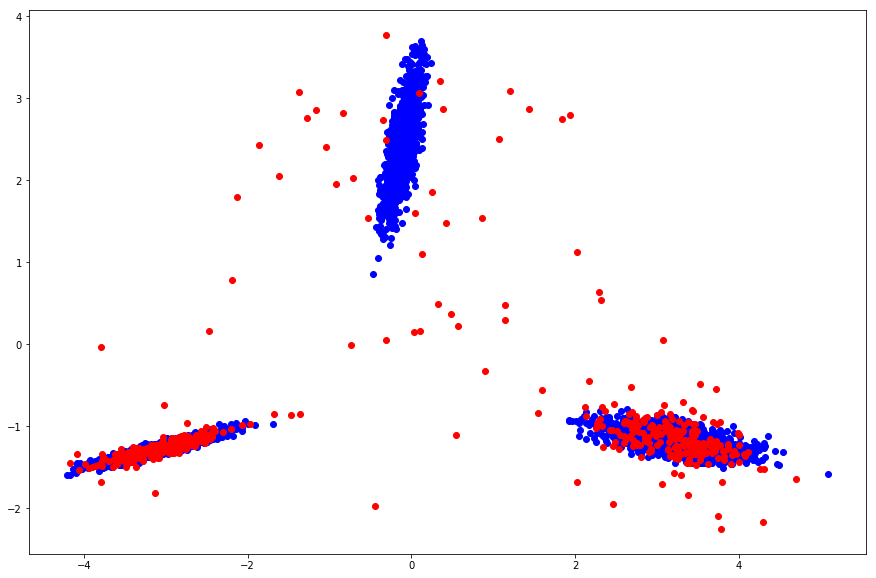

In [47]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, 10)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

In [49]:
sample_probs = disc(Variable(torch.from_numpy(samples).float()))[:, 0].data.numpy()

In [50]:
sample_probs.shape

(5087,)

In [60]:
idx = np.where(sample_probs > 0.5)
good_samples = samples[idx]

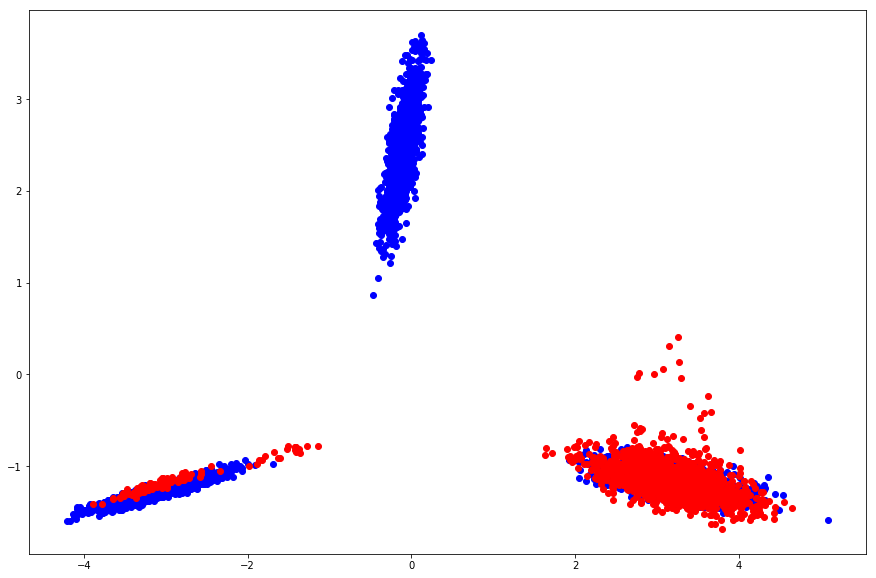

In [61]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), good_samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
# plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

In [62]:
true_probs = disc(Variable(data.X))[:, 0].data.numpy()
np.min(true_probs)

0.29538473

In [63]:
bad_idx = np.where(true_probs < 0.5)
bad_data = data.X.numpy()[bad_idx]

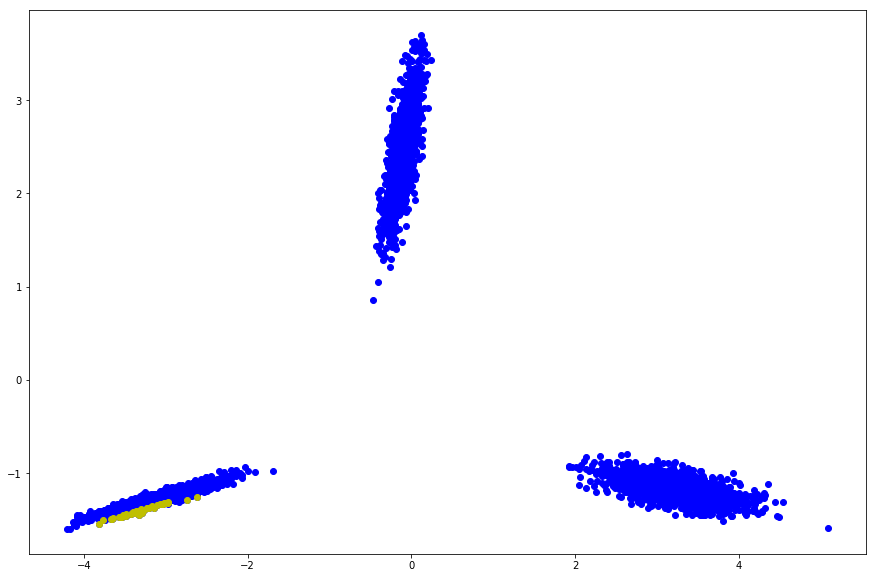

In [64]:
plt.figure(figsize=(15, 10))
x_r, x_b = pca(data.X.numpy(), bad_data)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_b[:, 0], x_b[:, 1], 'yo')